In [1]:
import hashlib
import os
import pickle
from hwcomponents_cacti import CactiSRAM
from hwcomponents_library import AladdinAdder, AladdinMultiplier

from fastfusion.frontend.architecture import Memory
from fastfusion.frontend.specification import Specification
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_sims
from fastfusion.mapper.simanneal.wrappers import join_sims

import copy
import time
from fastfusion import Specification
from fastfusion.mapper.metrics import Metrics
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_sims
from fastfusion.mapper.FFM.joining.sim import SIM
from fastfusion.mapper.FFM.joining.simexplore import join_sims
import fastfusion.mapper.FFM.exploration.mapper_one_einsum as mapper_one_einsum

from fastfusion.mapper.FFM.exploration.mapping_filter_tags.ffmt import get_ffmt_tag
from fastfusion.mapper.FFM.exploration.mapping_filter_tags.onesplit import get_one_split_tag
from fastfusion.mapper.FFM.pareto import PartialMappings

# TODO: area is an alias for get_area
# TODO: Separate energy and area
# TODO: Move scaling into main hwcomponents repo
# TODO: Function that just returns the hwcomponents component
# TODO: Is all the initial right consolidation necessary?
# TODO: Datawidth calculation for energy

# TODO: Reference specific tensor names in constraints, even if those tensors are not in
# a particular Einsum. Also have the error mrssages for parsing errors list which Einsum
# failed. Einsums that aren't in the tensor should resolve to NotInThisEinsum(), which =
# nothing.

# TODO: Make a setting for the below two in the spec
# TODO: Generate pmappings one Einsum at a time. Once we've made compatibility, check it
# against the previously-generated compatibilities and stop if there's no match.
# TODO: Once the previous is done, also add a forward check. Once the compatibilities of
# a particular Einsum are generated, we can immediately check the previous Einsums.
# TODO: Make the mapping return an object that supports union operators and stuff
# TODO: The fix in mapping.py

# TODO: have inf a supported value in YAMLs
# TODO: programatically check if any storages are below all backing storages. If so,
# don't record reservations for it.
# TODO: If any memroies have size > sum of all tensor sizes, also don't record reservations
# TODO: constrained_loops for  

# TODO: Tile shape check spatial all big or all small-- need to check mixes

spec = Specification.from_yaml(
    f"architecture/four_level.arch.yaml",
    "workloads/mha_full.workload.yaml",
    "workloads/mha_full.renames.yaml",
)

# adder = AladdinAdder(technology="7e-9", width=16)
# multiplier = AladdinMultiplier(technology="7e-9", width=8)
# mac_area = adder.get_area() + multiplier.get_area()

# base_local_buffer_size = 4 * 1024 * 1024 * 8
# base_local_buffer = CactiSRAM(technology="7e-9", width=128, depth=base_local_buffer_size // 128)
# base_global_buffer_size = 128 * 1024 * 1024 * 8
# base_global_buffer = CactiSRAM(technology="7e-9", width=1024, depth=base_global_buffer_size // 1024)
# area_budget = (mac_area * 128 * 128 + base_local_buffer.get_area()) * 4 + base_global_buffer.get_area()

# TARGET_TECH_NODE = "4nm"
# adder = AladdinAdder(technology=TARGET_TECH_NODE, width=16)
# multiplier = AladdinMultiplier(technology=TARGET_TECH_NODE, width=8)
# mac_area = adder.get_area() + multiplier.get_area()
# base_local_buffer_size = 1 * 1024 * 1024 * 8
# base_local_buffer = CactiSRAM(technology=TARGET_TECH_NODE, width=128, depth=base_local_buffer_size // 128)
# base_global_buffer_size = 16.5 * 1024 * 1024 * 8
# base_global_buffer = CactiSRAM(technology=TARGET_TECH_NODE, width=1024, depth=base_global_buffer_size // 1024)
# area_budget = (mac_area * 512 * 1024 + base_local_buffer.get_area()) * 4 + base_global_buffer.get_area()

print(f"COMPUTE ENERGY / 8 ????????????")
print(f"COMPUTE ENERGY / 8 ????????????")
print(f"COMPUTE ENERGY / 8 ????????????")
print(f"COMPUTE ENERGY / 8 ????????????")
print(f"COMPUTE ENERGY / 8 ????????????")

objective = lambda df: df['Total_Latency']# * df['Total_Energy']

def get_fused_mappings(
        spec: Specification,
        n_pes,
        pe_x,
        pe_y,
        tagger=None, 
        # fuse=True,
        parameterization="",
        return_mappings=False,
        max_latency: float = None
    ) -> PartialMappings:
    print(f'Running parameterization {parameterization}')
    cachekey = (n_pes, pe_x, pe_y, parameterization)
    fname = parameterization + " " + hashlib.md5(str(cachekey).encode()).hexdigest()
    if os.path.exists(f"cache2/{fname}.pkl"):
        print(f"Loading from cache2: {fname}")
        mappings = pickle.load(open(f"cache2/{fname}.pkl", "rb"))
        if return_mappings:
            return mappings
        return objective(mappings.data).min(), mappings
    return 0, None
    spec = copy.deepcopy(spec)
    # local_buffer: Memory = spec.architecture.nodes["LocalBuffer"]
    # local_buffer.attributes.size = local_buffer_model.width * local_buffer_model.depth
    # local_buffer.spatial.fanout["X"] = n_pes
    global_buffer: Memory = spec.architecture.nodes["GlobalBuffer"]
    main_memory: Memory = spec.architecture.nodes["MainMemory"]
    if parameterization == "Unfused":
        main_memory.constraints.storage.keep = "All()"
    elif parameterization == "FlashAttention B":
        main_memory.constraints.storage.keep = "All() - (I | Q | K | V | QK | QK_softmax)"# - QK_softmax"# - Q - K - V - I"
        main_memory.constraints.storage.bypass = "I | Q | K | V | QK | QK_softmax"#Q | K | V | I"# | QK | FFA"
    elif parameterization == "FlashAttention A":
        main_memory.constraints.storage.keep = "All() - (QK | QK_softmax)"# - QK_softmax"# - Q - K - V - I"
        main_memory.constraints.storage.bypass = "QK | QK_softmax"#Q | K | V | I"# | QK | FFA"
    elif parameterization == "FFM":
        main_memory.constraints.storage.keep = "~Intermediates()" #"# | AV | Z "
        main_memory.constraints.storage.bypass = "I | Q | K | V | QK"#Q | K | V | I"# | QK | FFA"
        pass
    elif parameterization == "Weight-Stationary":
        global_buffer.constraints.dataflow.storage_orders.append(
            ["weight", "~weight"]
        )
    elif parameterization == "Input-Stationary":
        global_buffer.constraints.dataflow.storage_orders.append(
            ["input", "~input"]
        )
    elif parameterization == "Output-Stationary":
        global_buffer.constraints.dataflow.storage_orders.append(
            ["output", "~output"]
        )
    else:
        assert False, f"Parameterization {parameterization} not supported"
        
        
    register: Memory = spec.architecture.nodes["Register"]
    register.spatial.fanout["X"] = pe_x
    register.spatial.fanout["Y"] = pe_y
    register.spatial.fanout["Z"] = n_pes
    
    spec.calculate_component_energy_area()
    flattened_architecture = spec.get_flattened_architecture()
    t0 = time.time()
    sims, decompress_data = get_sims(spec, flattened_architecture, tagger=tagger, metrics=Metrics.LATENCY | Metrics.ENERGY) # metrics=Metrics.ENERGY | # | Metrics.PER_COMPONENT_ENERGY)
    pmapping_time = time.time() - t0
    total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
    n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
    print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} pareto optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')
    t0 = time.time()
    mappings = join_sims(sims, spec, flattened_architecture)
    join_time = time.time() - t0
    mappings.decompress(decompress_data)
    print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")
    pickle.dump(mappings, open(f"cache22/{fname}.pkl", "wb"))
    if return_mappings:
        return mappings
    return objective(mappings.data).min(), mappings

# print(f'Overall area budget: {area_budget * 1e6} mm^2')

parameterization2edp = {}
parameterization2mappings = {}

parameterizations = [
    "Unfused",
    "Fixed-Dataflow",
    "FlashAttention A",
    "FlashAttention B",
    "FFM"
]#, "Unfused"] # "FFM", "Unfused", "FlashAttention"]#, "FlashAttention", "Unfused"]

# TARGET_TECH_NODE = "4nm"
# adder = AladdinAdder(technology=TARGET_TECH_NODE, width=16)
# multiplier = AladdinMultiplier(technology=TARGET_TECH_NODE, width=8)
# mac_area = adder.get_area() + multiplier.get_area()

# # glb_size = 512 * 1024 * 1024 * 8
# # glb = CactiSRAM(technology=TARGET_TECH_NODE, width=1024, depth=glb_size // 1024)
# llb_size = 1 * 1024 * 1024 * 8
# llb = CactiSRAM(technology=TARGET_TECH_NODE, width=128, depth=llb_size // 128)

def binary_search_glb_size(area_remaining):
    print(f"Area remaining: {area_remaining}")
    # Binary search to nearest 1MB
    low = 1
    high = 1024
    while low < high:
        mid = round((low + high) / 2)
        size = mid * 1024 * 1024 * 8
        glb = CactiSRAM(technology=TARGET_TECH_NODE, width=1024, depth=size // 1024)
        if glb.get_area() > area_remaining:
            if mid == high:
                break
            print(f"High {high} -> {mid}")
            high = mid
        else:
            if mid == low:
                break
            print(f"Low {low} -> {mid}")
            low = mid
    return low * 1024 * 1024 * 8

mac_x, mac_y = 128, 128
# for mac_x, mac_y in [(256, 256), (1024, 1024), (1024, 512), (512, 512), (512, 256)]:
for n_pes in [1, 2, 4, 8, 16, 32, 64, 128, 256]:#2, 4, 8, 16, 32]:
    # total_mac_area = mac_area * mac_x * mac_y
    # area_remaining = area_budget - n_pes * (llb.get_area() + total_mac_area)
    # if area_remaining < 0:
    #     continue
    # glb_size = binary_search_glb_size(area_remaining)
    # glb = CactiSRAM(technology=TARGET_TECH_NODE, width=1024, depth=glb_size // 1024)
    # glb_size = 128 * 1024 * 1024 * 8
    # glb = CactiSRAM(technology=TARGET_TECH_NODE, width=1024, depth=glb_size // 1024)
    max_latency = None
    
    # glb_MB = glb_size // 1024 // 1024 // 8
    # llb_MB = llb_size // 1024 // 1024 // 8
    
    print(f"\n\n")
    print(f"=" * 100)
    print(f"MAC dims: {mac_x}x{mac_y}")
    print(f"=" * 100)

    for parameterization in parameterizations: # "fuse"
        while True:
            try:
                x, mappings = get_fused_mappings(
                    spec,
                    n_pes,
                    mac_x,
                    mac_y,
                    parameterization=parameterization,
                    max_latency=max_latency
                )
                break
            except Exception as e:
                max_latency *= 2
                print(f"Error: {e}")
        if "Weight-Stationary" not in parameterization:
            max_latency = x
        if x != 0:
            parameterization2edp[f"{parameterization} {n_pes} {mac_x}x{mac_y}"] = x
            parameterization2mappings[f"{parameterization} {n_pes} {mac_x}x{mac_y}"] = mappings

INFO        Loading yaml file architecture/four_level.arch.yaml
INFO        Found top key variables in architecture/four_level.arch.yaml
INFO        Found top key architecture in architecture/four_level.arch.yaml
INFO        Found top key component_classes in architecture/four_level.arch.yaml
INFO        Loading yaml file workloads/mha_full.workload.yaml
INFO        Found top key workload in workloads/mha_full.workload.yaml
INFO        Loading yaml file workloads/mha_full.renames.yaml
INFO        Found top key renames in workloads/mha_full.renames.yaml
WARNING     Loading configuration file from /root/.config/fastfusion/config.yaml


COMPUTE ENERGY / 8 ????????????
COMPUTE ENERGY / 8 ????????????
COMPUTE ENERGY / 8 ????????????
COMPUTE ENERGY / 8 ????????????
COMPUTE ENERGY / 8 ????????????



MAC dims: 128x128
Running parameterization Unfused
Running parameterization Fixed-Dataflow
Running parameterization FlashAttention A
Running parameterization FlashAttention B
Running parameterization FFM



MAC dims: 128x128
Running parameterization Unfused
Running parameterization Fixed-Dataflow
Running parameterization FlashAttention A
Running parameterization FlashAttention B
Running parameterization FFM



MAC dims: 128x128
Running parameterization Unfused
Running parameterization Fixed-Dataflow
Running parameterization FlashAttention A
Running parameterization FlashAttention B
Running parameterization FFM



MAC dims: 128x128
Running parameterization Unfused
Running parameterization Fixed-Dataflow
Running parameterization FlashAttention A
Running parameterization FlashAttention B
Running parameterization FFM



MAC dims:

Unfused 64 128x128
Fixed-Dataflow 64 128x128
FlashAttention A 64 128x128
FlashAttention B 64 128x128
FFM 64 128x128
Unfused 256 128x128
Fixed-Dataflow 256 128x128
FlashAttention A 256 128x128
FlashAttention B 256 128x128
FFM 256 128x128
Fixed-Dataflow: {'1024k': np.float64(0.2547744431673356), '4096k': np.float64(0.8187698014684737)}
Elementwise-Only: {'1024k': np.float64(0.22483452539171045), '4096k': np.float64(0.4457559026459059)}
FlashAttention A: {'1024k': np.float64(0.24816509998450278), '4096k': np.float64(0.5478730770875776)}
FlashAttention B: {'1024k': np.float64(0.25722170399946104), '4096k': np.float64(0.7000318179271331)}
FFM: {'1024k': np.float64(0.2597164356234769), '4096k': np.float64(1.0)}


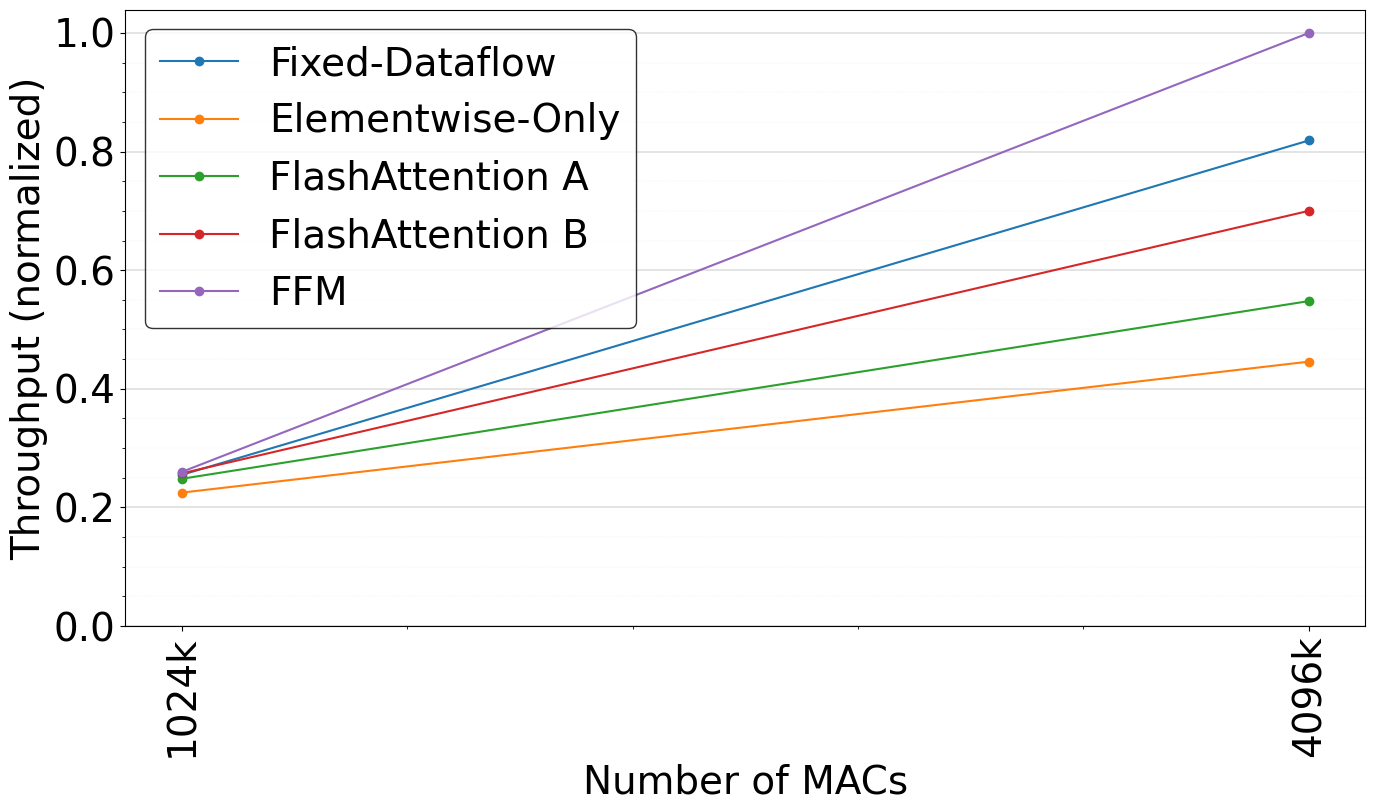

In [2]:

import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams.update({'font.size': 28})

def plot_default_formatting(ax, grid_axis='both'):
    ax.tick_params(axis='both', which='major')#, labelsize=20)
    ax.tick_params(axis='both', which='minor')#, labelsize=20)
    legend = ax.legend()
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('black')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    if ax.get_legend() is None:
        legend = ax.legend(fontsize=24, ncol=2)
    ax.minorticks_on()
    ax.grid(axis=grid_axis, which='major', linestyle='-', linewidth='0.3', color='gray')
    ax.grid(axis=grid_axis, which='minor', linestyle='--', linewidth='0.1', color='lightgray')
    

def make_bar_chart(
    data,
    title,
    xlabel,
    ylabel,
    y_scale,
    output_file=None,
    normalize: bool = False,
    ylim=(None, None),
    xlim=(None, None),
):
    """
    Create a bar chart from the given data and save it as a PDF.
    """
    plt.figure(figsize=(16, 8))
    
    if isinstance(data, dict) and isinstance(next(iter(data.values())), dict):
        bar_width = 0#0.8 / len(data)
        keys = list(next(iter(data.values())).keys())
        x = range(len(keys))
        first = next(iter(data.values()))
            
        for i, (label, values) in enumerate(data.items()):
            bar_positions = [pos + i * bar_width for pos in x]
            to_plot = values
            if normalize:
                to_plot = {k: v / first[k] for k, v in values.items()}
            # bars = plt.bar(bar_positions, to_plot.values(), width=bar_width, label=label)
            plt.plot(bar_positions, to_plot.values(), label=label, marker='o')
        plt.xticks([pos + (len(data) - 1) * bar_width / 2 for pos in x], keys)
        plt.legend(loc='upper right', fontsize=10)
    else:
        keys = list(data.keys())
        bars = plt.bar(keys, data.values())

    # Set logarithmic scale for Y-axis if specified
    if y_scale == 'log':
        plt.yscale('log')

    # Add labels and title
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(ylim)
    plt.xlim(xlim)
    

    # Rotate X-axis labels vertically
    plt.xticks(rotation=90)
    
    plot_default_formatting(plt.gca(), grid_axis='y')
    
    if output_file is not None:
        with open(output_file, 'wb') as f:
            plt.savefig(f, format='pdf', bbox_inches='tight')

    # Show the plot
    plt.show()
# print()
# make_bar_chart(
#     parameterization2edp,
#     title=None,
#     xlabel=None,
#     ylabel="EDP",
#     y_scale='linear',
# )

# Now we're going to make a line chart. Have the X axis be (Number of MACs, GLB size)
# and the Y axis be EDP. We'll plot a line for each parameterization.

# Get the keys from parameterization2edp
keys = list(parameterization2edp.keys())
entries = {}
for key in keys:
    print(key)
    parts = key.split(" ")
    mac_dims = parts[-1]
    n_pes = int(parts[-2])
    n_macs = int(mac_dims.split("x")[0]) * int(mac_dims.split("x")[1]) * n_pes
    entry = " ".join(parts[:-2])
    n_macs = f"{n_macs // 1024}k"
    entries.setdefault(entry, {})[n_macs] = 1 / (parameterization2edp[key] / 1.05e9 * 1000)
    
max_throughput = max(max(e.values()) for e in entries.values())
entries = {k: {k2: v2 / max_throughput for k2, v2 in v.items()} for k, v in entries.items()}
    
all_keys = set.union(*[set(entries.keys()) for entries in entries.values()])
for name, e in entries.items():
    for k in all_keys:
        if k not in e:
            e[k] = 0
    entries[name] = {k: e[k] for k in sorted(e.keys(), key=lambda x: int(x.split("k")[0]))}

name_changes = {
    "Unfused": "Elementwise-Only",
    "FlashAttention A": "FlashAttention A",
    "FlashAttention B": "FlashAttention B",
    "FFM": "FFM",
}
for name, e in list(entries.items()):
    if name in name_changes:
        entries[name_changes[name]] = entries.pop(name)
        
# Print as a table
for name, e in entries.items():
    print(f"{name}: {e}")

make_bar_chart(entries, title=None, xlabel="Number of MACs", ylabel="Throughput (normalized)", y_scale='linear', output_file="mapsapce_compare.pdf", normalize=False, ylim=(0, None), xlim=(None, None))

In [3]:
# # glb_MB = 128
# # sram_MB = 4
# # parameterization = ""

# # cur_area_budget = area_budget
# # glb_size = glb_MB * 1024 * 1024 * 8
# # glb = CactiSRAM(technology="7e-9", width=1024, depth=glb_size // 1024)
# # cur_area_budget -= glb.get_area()
# # # for sram_MB in [0.25, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]:
# # sram_size = sram_MB * 1024 * 1024 * 8
# # llb = CactiSRAM(technology="7e-9", width=128, depth=sram_size // 128)
# # remaining_area = cur_area_budget / 4 - llb.get_area() # Per-MXU
# # mac_dims = int((remaining_area / mac_area) ** 0.5)
# # print(f"Global buffer: {glb_MB} MB, Local buffer: {sram_MB} MB, MAC dims: {mac_dims}x{mac_dims}")
# # print(f'GLB read energy: {glb.read()}. LLB read energy: {llb.read()}')

from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_per_tensor_size, get_num_computes
for tensor, size in sorted(get_per_tensor_size(spec).items(), key=lambda x: x[1], reverse=True):
    print(f"{tensor}: {size}")
print(f"Number of computes: {get_num_computes(spec)}")

Z
WK
WFFB
Q
I_in
I
WZ
WQ
V
K
AV
WFFA
FFA
WV
QK_softmax
FFB
QK
FFA: 536870912
QK_softmax: 536870912
QK: 536870912
Z: 134217728
Q: 134217728
I_in: 134217728
I: 134217728
V: 134217728
K: 134217728
AV: 134217728
FFB: 134217728
WFFB: 67108864
WFFA: 67108864
WK: 16777216
WZ: 16777216
WQ: 16777216
WV: 16777216
Number of computes: 6735179808768


In [4]:
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_rank_variable_bounds_for_all_einsums

parameterization2latencycols: list[dict[str, float]] = []
for p, mappings in parameterization2mappings.items():
    mappings._data = mappings.data.sort_values(by="Total_Latency", ascending=True)
    rank_variable_bounds = get_rank_variable_bounds_for_all_einsums(spec)

    row = {
        "Parameterization": p,
    }
    for col in mappings.data.columns:
        print(f'{col}: {mappings.data.iloc[0][col]}')
        # if "Latency" in col:
        # if "Total_Latency" in col:
        if "Latency" in col:
        # if "Total_Energy" in col:
            row[col] = mappings.data.iloc[0][col]
    parameterization2latencycols.append(row)

    # from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
    # from IPython.display import SVG
    # newmapping = make_mapping(mappings.data.iloc[0], spec.workload.einsum_names, get_rank_variable_bounds_for_all_einsums(spec))
    # for col in mappings.data.columns:
    #     print(f'{col}: {mappings.data.iloc[0][col]}')

    # display(SVG(newmapping.render()))
    
from fastfusion.accelerated_imports.pd import DataFrame
df = DataFrame(parameterization2latencycols)
from fastfusion.accelerated_imports import pd
pd.set_option('display.max_columns', None)
df
    
# {'n1'}-1 || [GlobalBuffer] T1 sz 0 above 1
# TODO: Re-add -1 to the mapper one eisnum freenig
# compatibility2sims['Matmul1']["{'n1'}-1 || [GlobalBuffer] T1 sz 0 above 1"]
# Above 1: 8192
# Above 2: 8321
# compatibility2sims['Matmul2']["{'n1'}-1 || [GlobalBuffer] T1 sz 0 above 1, [GlobalBuffer] T2 sz 0 above 0"]

FFB__tile_shape0: 16384.0
FFB__tile_shape1: 4096.0
FFB__tile_shape2: 1.0
FFB__tile_shape3: 64.0
FFB__tile_shape4: 128.0
FFB__tile_shape5: 1.0
FFB__tile_shape6: 1.0
FFB__tile_shape7: 128.0
FFB__tile_shape8: 1.0
FFB__tile_shape9: 1.0
FFBmetric_Latency: 2097152.0
FFBcompute_Latency: 2097152.0
FFBGlobalBuffer_Latency: 0
FFBMainMemory_Latency: 1262389.868401211
FFBmetric_Energy: 17.83001516081154
FFB__MAPPING: type=None nodes=[Storage(type=None, tensors=['WFFB'], memory='MainMemory', memory_object=Memory(type=None, name='MainMemory', attributes=MemoryAttributes(type=None, technology=7e-9, global_cycle_seconds=1e-09, n_instances=1, energy_scale=1, area_scale=1, energy=None, area=1, datawidth=8, size=9999999999999, multiple_buffering=1, shared_read_write_bandwidth=4678.0952380952385, read_bandwidth=inf, write_bandwidth=inf, version='0.5', width=4678), spatial=Spatial(type=None, fanout={}), constraints=ConstraintGroup(type=None, name=None, spatial=[], temporal=Temporal(type=None, version='0.5'

Imetric_Energy: 0.00184348049408
IRESOURCE_GlobalBuffer_LEVEL_2: nan
IRESOURCE_GlobalBuffer_LEVEL_1: 16777728.0
I__MAPPING: type=None nodes=[Storage(type=None, tensors=['I_in'], memory='MainMemory', memory_object=Memory(type=None, name='MainMemory', attributes=MemoryAttributes(type=None, technology=7e-9, global_cycle_seconds=1e-09, n_instances=1, energy_scale=1, area_scale=1, energy=None, area=1, datawidth=8, size=9999999999999, multiple_buffering=1, shared_read_write_bandwidth=4678.0952380952385, read_bandwidth=inf, write_bandwidth=inf, version='0.5', width=4678), spatial=Spatial(type=None, fanout={}), constraints=ConstraintGroup(type=None, name=None, spatial=[], temporal=Temporal(type=None, version='0.5', reuse='All', loop_bounds=[], rmw_first_update=[]), storage=Storage(type=None, bypass='I | Q | K | V | QK | QK_softmax', keep='All() - (I | Q | K | V | QK | QK_softmax)', coalesce='All', tile_shape=[]), dataflow=Dataflow(type=None, storage_orders=[])), component_class='DRAM', enabled

,Parameterization,FFBmetric_Latency,FFBcompute_Latency,FFBGlobalBuffer_Latency,FFBMainMemory_Latency,FFAmetric_Latency,FFAcompute_Latency,FFAGlobalBuffer_Latency,FFAMainMemory_Latency,Zmetric_Latency,Zcompute_Latency,ZGlobalBuffer_Latency,ZMainMemory_Latency,AVmetric_Latency,AVcompute_Latency,AVGlobalBuffer_Latency,AVMainMemory_Latency,QK_softmaxmetric_Latency,QK_softmaxcompute_Latency,QK_softmaxGlobalBuffer_Latency,QK_softmaxMainMemory_Latency,QKmetric_Latency,QKcompute_Latency,QKGlobalBuffer_Latency,QKMainMemory_Latency,Qmetric_Latency,Qcompute_Latency,QGlobalBuffer_Latency,QMainMemory_Latency,Kmetric_Latency,Kcompute_Latency,KGlobalBuffer_Latency,KMainMemory_Latency,Vmetric_Latency,Vcompute_Latency,VGlobalBuffer_Latency,VMainMemory_Latency,Imetric_Latency,Icompute_Latency,IGlobalBuffer_Latency,IMainMemory_Latency,metric_Latency
0,Unfused 64 128x128,2.097152e+06,2097152.0,0,1.262390e+06,2.097152e+06,2097152.0,0,1.262390e+06,524288.000000,524288.0,0,487741.540064,1.377153e+06,65536.0,0,1.377153e+06,8388608.0,8388608.0,0,1.836203e+06,1.377153e+06,65536.0,0,1.377153e+06,524288.000000,524288.0,0,487741.540064,524288.000000,524288.0,0,487741.540064,524288.000000,524288.0,0,487741.540064,2097152.0,2097152.0,0,459050.861237,1.953152e+07
1,Fixed-Dataflow 64 128x128,2.097152e+06,2097152.0,0,8.033390e+05,2.097152e+06,2097152.0,0,5.738136e+05,524288.000000,524288.0,0,258216.109446,2.295254e+05,131072.0,0,2.295254e+05,8388608.0,8388608.0,0,NaN,2.295254e+05,65536.0,0,2.295254e+05,524288.000000,524288.0,0,28690.678827,524288.000000,524288.0,0,258216.109446,524288.000000,524288.0,0,258216.109446,2097152.0,2097152.0,0,229525.430618,1.723627e+07
2,FlashAttention A 64 128x128,2.097152e+06,2097152.0,0,1.262390e+06,2.097152e+06,2097152.0,0,1.262390e+06,524288.000000,524288.0,0,487741.540064,4.590509e+05,65536.0,0,4.590509e+05,8388608.0,8388608.0,0,NaN,4.590509e+05,65536.0,0,4.590509e+05,524288.000000,524288.0,0,487741.540064,524288.000000,524288.0,0,487741.540064,524288.000000,524288.0,0,487741.540064,2097152.0,2097152.0,0,459050.861237,1.769532e+07
3,FlashAttention B 64 128x128,2.097152e+06,2097152.0,0,1.262390e+06,2.097152e+06,2097152.0,0,1.262390e+06,524288.000000,524288.0,0,487741.540064,2.295254e+05,65536.0,0,2.295254e+05,8388608.0,8388608.0,0,NaN,6.553600e+04,65536.0,0,NaN,524288.000000,524288.0,0,28690.678827,524288.000000,524288.0,0,28690.678827,524288.000000,524288.0,0,28690.678827,2097152.0,2097152.0,0,229525.430618,1.707228e+07
4,FFM 64 128x128,2.097152e+06,2097152.0,0,6.885763e+05,2.097152e+06,2097152.0,0,4.590509e+05,524288.000000,524288.0,0,114762.715309,6.553600e+04,65536.0,0,NaN,8388608.0,8388608.0,0,NaN,6.553600e+04,65536.0,0,NaN,524288.000000,524288.0,0,28690.678827,524288.000000,524288.0,0,28690.678827,524288.000000,524288.0,0,28690.678827,2097152.0,2097152.0,0,229525.430618,1.690829e+07
5,Unfused 256 128x128,1.262390e+06,1048576.0,0,1.262390e+06,1.262390e+06,1048576.0,0,1.262390e+06,487741.540064,131072.0,0,487741.540064,1.377153e+06,16384.0,0,1.377153e+06,2097152.0,2097152.0,0,1.836203e+06,1.377153e+06,16384.0,0,1.377153e+06,487741.540064,131072.0,0,487741.540064,487741.540064,131072.0,0,487741.540064,487741.540064,131072.0,0,487741.540064,524288.0,524288.0,0,459050.861237,9.851491e+06
6,Fixed-Dataflow 256 128x128,8.033390e+05,524288.0,0,8.033390e+05,5.738136e+05,524288.0,0,5.738136e+05,258216.109446,131072.0,0,258216.109446,2.295254e+05,131072.0,0,2.295254e+05,2097152.0,2097152.0,0,NaN,2.295254e+05,131072.0,0,2.295254e+05,131072.000000,131072.0,0,28690.678827,258216.109446,131072.0,0,258216.109446,258216.109446,131072.0,0,258216.109446,524288.0,524288.0,0,229525.430618,5.363364e+06
7,FlashAttention A 256 128x128,1.262390e+06,1048576.0,0,1.262390e+06,1.262390e+06,1048576.0,0,1.262390e+06,487741.540064,131072.0,0,487741.540064,4.590509e+05,16384.0,0,4.590509e+05,2097152.0,2097152.0,0,NaN,4.590509e+05,131072.0,0,4.590509e+05,487741.540064,131072.0,0,487741.540064,487741.540064,131072.0,0,487741.540064,487741.540064,131072.0,0

In [5]:
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_rank_variable_bounds_for_all_einsums

mac_dims = int((((area_budget - glb.get_area()) / 4 - llb.get_area()) / mac_area)** 0.5)
mappings = list(parameterization2mappings.values())[0]
mappings._data = mappings.data.sort_values(by="Total_Latency", ascending=True).head()
rank_variable_bounds = get_rank_variable_bounds_for_all_einsums(spec)
from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
newmapping = make_mapping(mappings.data.iloc[0], spec.workload.einsum_names, get_rank_variable_bounds_for_all_einsums(spec))
a = {}
for col in mappings.data.columns:
    print(f'{col}: {mappings.data.iloc[0][col]}')
    if "Latency" in col:
        a[col] = mappings.data.iloc[0][col]
display(SVG(newmapping.render()))

NameError: name 'area_budget' is not defined

In [ ]:
assert False

from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_rank_variable_bounds_for_all_einsums

sram_size = 0.5 * 1024 * 1024 * 8
llb = CactiSRAM(technology="7e-9", width=128, depth=sram_size // 128)
mac_dims = int((((area_budget - glb.get_area()) / 4 - llb.get_area()) / mac_area)** 0.5)
mappings = get_fused_mappings(
    spec,
    mac_dims,
    llb,
    glb,
    return_mappings=True,
    parameterization="FFM"
)
mappings._data = mappings.data.sort_values(by="Total_Latency", ascending=True).head()
rank_variable_bounds = get_rank_variable_bounds_for_all_einsums(spec)
from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
newmapping = make_mapping(mappings.data.iloc[0], spec.workload.einsum_names, get_rank_variable_bounds_for_all_einsums(spec))
b = {}
for col in mappings.data.columns:
    print(f'{col}: {mappings.data.iloc[0][col]}')
    if "Latency" in col:
        b[col] = mappings.data.iloc[0][col]
display(SVG(newmapping.render()))

In [ ]:
df = pd.DataFrame([a, b])
df